### Script for identifying TCs in Bukovsky CONUS regions (1995–2017)
### in order to link to flood characteristics
### date created: 21 June 2021
### author: Erin Dougherty (doughert@ucar.edu)

In [1]:
import math 
import numpy as np
import pandas as pd
import matplotlib as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
from netCDF4 import Dataset, num2date
from datetime import datetime, date, timedelta
import glob
import xarray as xr
#from wrf import getvar, ALL_TIMES

### import TC track data 

In [2]:
### import Best track data
pd.set_option('display.max_columns', None)
ebt = pd.read_csv('/glade/work/doughert/flooddata/MS_River_floods/ebtrk_atl_1988_2017_2.csv', header=0, na_values=-99)


### remove storms that were before 1995 and after 2017

In [3]:
ebt_00 = ebt[ebt['year']>=1995]
ebt_0013 = ebt_00[ebt_00['year']<=2017].reset_index()

# drop column labeled "index"
ebt_0013 = ebt_0013.drop(['index'], axis=1)
print(len(ebt_00))
print(len(ebt_0013))

### find the mean of the 34 kt wind radii
ebt_0013['mean_r34'] = ebt_0013[['ne_r34','se_r34', 'sw_r34','nw_r34']].mean(axis=1)

### make long negative 
ebt_0013['long'] = -ebt_0013['long']

## get rid of obs too far south
ebt_0013_us = ebt_0013[ebt_0013['lat']>=20].reset_index()
ebt_0013_us = ebt_0013_us.drop(['index'], axis=1)

print(len(ebt_0013_us))

### convert mean radii of 34 kt winds from nm -->km
ebt_0013_us['mean_r34_km'] = ebt_0013_us['mean_r34']*1.852

10849
10849
7363


### compute lat/lon bounds of 34 kt wind radii

In [4]:
import math

###(from: https://stackoverflow.com/questions/7222382/get-lat-long-given-current-point-distance-and-bearing)

R = 6378.1 #Radius of the Earth
d =  ebt_0013_us['mean_r34_km'] #Distance in km

lat1 = [math.radians(ebt_0013_us['lat'].iloc[i]) for i in range(len(ebt_0013_us))] #Current lat point converted to radians
lon1 = [math.radians(ebt_0013_us['long'].iloc[i]) for i in range(len(ebt_0013_us))] #Current long point converted to radians

# compute northern most lat
brng = np.radians(0) #Bearing is 90 degrees converted to radians.

latu = [math.asin( math.sin(lat1[i])*math.cos(d[i]/R) +
         math.cos(lat1[i])*math.sin(d[i]/R)*math.cos(brng)) for i in range(len(ebt_0013_us))]

lonu = [lon1[i] + math.atan2(math.sin(brng)*math.sin(d[i]/R)*math.cos(lat1[i]),
        math.cos(d[i]/R)-math.sin(lat1[i])*math.sin(latu[i])) for i in range(len(ebt_0013_us))]

latu = [math.degrees(latu[i]) for i in range(len(ebt_0013_us))]
lonu = [math.degrees(lonu[i]) for i in range(len(ebt_0013_us))]

# compute southern most lat
brng = np.radians(180) #Bearing is 90 degrees converted to radians.

latb = [math.asin( math.sin(lat1[i])*math.cos(d[i]/R) +
         math.cos(lat1[i])*math.sin(d[i]/R)*math.cos(brng)) for i in range(len(ebt_0013_us))]

lonb = [lon1[i] + math.atan2(math.sin(brng)*math.sin(d[i]/R)*math.cos(lat1[i]),
        math.cos(d[i]/R)-math.sin(lat1[i])*math.sin(latb[i])) for i in range(len(ebt_0013_us))]

latb = [math.degrees(latb[i]) for i in range(len(ebt_0013_us))]
lonb = [math.degrees(lonb[i]) for i in range(len(ebt_0013_us))]

# compute eastern most lon
brng = np.radians(90) #Bearing is 90 degrees converted to radians.

late = [math.asin( math.sin(lat1[i])*math.cos(d[i]/R) +
         math.cos(lat1[i])*math.sin(d[i]/R)*math.cos(brng)) for i in range(len(ebt_0013_us))]

lone = [lon1[i] + math.atan2(math.sin(brng)*math.sin(d[i]/R)*math.cos(lat1[i]),
        math.cos(d[i]/R)-math.sin(lat1[i])*math.sin(late[i])) for i in range(len(ebt_0013_us))]

late = [math.degrees(late[i]) for i in range(len(ebt_0013_us))]
lone = [math.degrees(lone[i]) for i in range(len(ebt_0013_us))]

# compute western most lon
brng = np.radians(270) #Bearing is 90 degrees converted to radians.

latw = [math.asin( math.sin(lat1[i])*math.cos(d[i]/R) +
         math.cos(lat1[i])*math.sin(d[i]/R)*math.cos(brng)) for i in range(len(ebt_0013_us))]

lonw = [lon1[i] + math.atan2(math.sin(brng)*math.sin(d[i]/R)*math.cos(lat1[i]),
        math.cos(d[i]/R)-math.sin(lat1[i])*math.sin(latw[i])) for i in range(len(ebt_0013_us))]

latw = [math.degrees(latw[i]) for i in range(len(ebt_0013_us))]
lonw = [math.degrees(lonw[i]) for i in range(len(ebt_0013_us))]


#### add columns to df

In [5]:
ebt_0013_us['r34_n'] = latu
ebt_0013_us['r34_s'] = latb
ebt_0013_us['r34_e'] = lone
ebt_0013_us['r34_w'] = lonw

### convert TC date to datetime object

In [6]:
### TC time and date in one column, converted to datetime
## convert dates to strings 
ebt_0013_us['mmddhh'] = ebt_0013_us['mmddhh'].apply(str)
ebt_0013_us['year'] = ebt_0013_us['year'].apply(str)

print(ebt_0013_us['mmddhh'].iloc[848][3:5])
print(ebt_0013_us['mmddhh'].iloc[849][4:6])

# put month into separate list
ebt_mnt = []

for i in range(len(ebt_0013_us)):
    if len(ebt_0013_us['mmddhh'].iloc[i])==5:
        ebt_mnt.append(ebt_0013_us['mmddhh'].iloc[i][0])
    else:
        ebt_mnt.append(ebt_0013_us['mmddhh'].iloc[i][0:2])
        
# day into separate list
ebt_day = []

for i in range(len(ebt_0013_us)):
    if len(ebt_0013_us['mmddhh'].iloc[i])==5:
        ebt_day.append(ebt_0013_us['mmddhh'].iloc[i][1:3])
    else:
        ebt_day.append(ebt_0013_us['mmddhh'].iloc[i][2:4])
        
# hour into separate list
ebt_hr = []

for i in range(len(ebt_0013_us)):
    if len(ebt_0013_us['mmddhh'].iloc[i])==5:
        ebt_hr.append(ebt_0013_us['mmddhh'].iloc[i][3:5])
    else:
        ebt_hr.append(ebt_0013_us['mmddhh'].iloc[i][4:6])
        
# create list of single date
ebt_0013_us['month'] = ebt_mnt
ebt_0013_us['day'] = ebt_day
ebt_0013_us['hour'] = ebt_hr


# create list of single date

ebt_0013_us['date'] = ebt_0013_us.apply(lambda x:datetime.strptime("{0} {1} {2} {3}".format(x['year'],x['month'], x['day'], x['hour']), "%Y %m %d %H"),axis=1)

06
2


### create polygons for 34 kt wind radii

In [8]:
# add column for mean radii of 34 kt wind in degrees (1 deg = 111 km)
ebt_0013_us['mean_r34_deg']= ebt_0013_us['mean_r34_km']/111

### create circular polygons with radius of 34 kt wind radii around center of each TC
from shapely import geometry
from geopandas import GeoSeries, GeoDataFrame
crs = {'init': 'epsg:4326'}

# turn center lat/lon into point
ebt_us_geo = GeoDataFrame(ebt_0013_us, crs=crs, geometry=[geometry.Point(x, y) for x, y in zip(ebt_0013_us.long, ebt_0013_us.lat)])
#print(ebt_us_geo.iloc[0:2])

buffer_shp =[]

# create circle with buffer distance of 34 kt wind radii (make sure in degreees!)
for i in range(len(ebt_us_geo)):
    if np.isnan(ebt_us_geo['mean_r34_deg'].iloc[i])==False and (ebt_us_geo['mean_r34_deg'].iloc[i]>0.0):
        shp = ebt_us_geo.geometry.iloc[i].buffer(ebt_us_geo['mean_r34_deg'].iloc[i])
        buffer_shp.append(shp)
    else:
        #print(i)
        buffer_shp.append(np.nan) 
    
# add column to df
ebt_us_geo['buffer_geo'] = GeoSeries(buffer_shp)

/glade/u/home/doughert/miniconda3/envs/pangeo3/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


#### drop columns with nans (i.e. no 34 kt wind radii) and change geometry column to buffers

In [9]:
ebt_us_nonan = ebt_us_geo.dropna(subset=['buffer_geo'])
ebt_us_nonan = ebt_us_nonan.rename({'geometry':'cntr_pt'},axis=1)
ebt_us_nonan = ebt_us_nonan.set_geometry('buffer_geo').reset_index()
ebt_us_nonan.geometry.name

'buffer_geo'

In [10]:
print(len(ebt_us_geo))
print(len(ebt_us_nonan))

7363
5019


### import U.S. state shapefile

In [11]:
from cartopy.io import shapereader
import geopandas as gp
from geopandas import GeoDataFrame

us_st = gp.GeoDataFrame.from_file(
    "/glade/work/doughert/flooddata/cb_2013_us_state_5m_2/cb_2013_us_state_5m.shp")
us_st.head()
print(len(us_st))
state = us_st['geometry'].values[0:56]

56


### import Bukovsky climate regions

In [12]:
from cartopy.io import shapereader
import geopandas as gp
from geopandas import GeoDataFrame

conus_reg = gp.GeoDataFrame.from_file( "/glade/work/doughert/asp/flood_storm_types/Bukovsky_conus_no_overlap/Bukovsky_conus_no_overlap.shp")
conus_reg.head()
print(len(conus_reg))

regions = conus_reg['geometry'].values

9


#### check to make sure buffer worked correctly

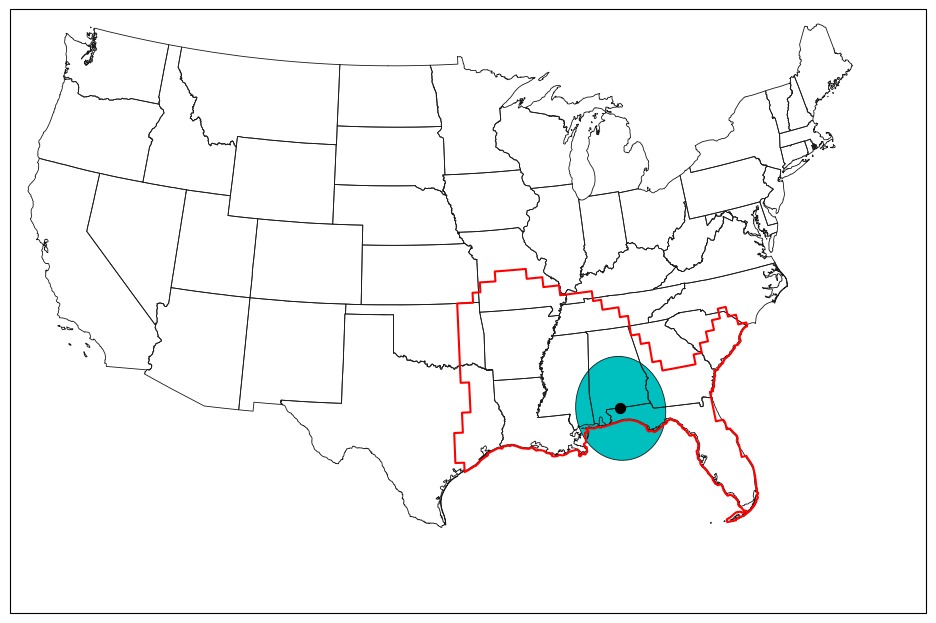

In [13]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.colors as colors

### plot accumulated rain rate as a countour plot
fig = plt.figure(figsize = (12,8), dpi = 100)

ax = plt.subplot(1, 1, 1,  projection=ccrs.LambertConformal(central_longitude=-100))
ax.add_geometries(state, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='0.1', linewidth = 0.6)
ax.add_geometries(regions[6:7], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='r', linewidth = 1.5)
ax.add_geometries(ebt_us_nonan['buffer_geo'][256:257], crs=ccrs.PlateCarree(), facecolor='c', edgecolor='0.1', linewidth = 0.6, zorder=1)
ax.set_extent([-120, -72, 21.5, 49], crs=ccrs.PlateCarree())
plt.scatter(ebt_us_nonan['long'].iloc[256:257],ebt_us_nonan['lat'].iloc[256:257], c='k', transform=ccrs.PlateCarree(), s=50, zorder=2)
plt.show()



### test if TC in southern region

#### create list of regions based on shapefile

In [14]:
conus_reg['region_list'] = ['Pac_NW', 'Pac_SW', 'MountainW', 'Desert', 'GP', 'Praire', 'South', 'Lakes', 'East']

### designate region having TC influence if region overlaps with 34 kt wind radii

In [15]:
tc_region = []
tc_name= []
tc_date = []
tc_pmin = []
tc_vmax = []

for f in range(len(conus_reg)):
    for t in range(len(ebt_us_nonan)):
        if (conus_reg['geometry'].iloc[f].intersects(ebt_us_nonan['buffer_geo'].iloc[t])):
            tc_region.append(conus_reg['region_list'].iloc[f])
            tc_name.append(ebt_us_nonan['Storm Name'].iloc[t])
            tc_date.append(ebt_us_nonan['date'].iloc[t])
            tc_pmin.append(ebt_us_nonan['pmin'].iloc[t])
            tc_vmax.append(ebt_us_nonan['vmax'].iloc[t])
#         else:
#             trop.append('NaN')


In [16]:
print(len(tc_region))
print(len(tc_name))

818
818


### make df of regions, dates, with TC influence

In [17]:
tc_region_df = pd.DataFrame({'Name':tc_name, 'Region':tc_region, 'Date':tc_date, 'Pmin':tc_pmin, 'Vmax':tc_vmax})

#### resample time series to daily and get TC counts for each day (1 = yes TC on day, 0 = no TC on day)

In [18]:
tc_region_daily = tc_region_df.groupby('Region').resample('D', on='Date').mean().reset_index()

In [19]:
tc_region_daily_ct = tc_region_daily.groupby(['Date', 'Region']).count().reset_index()

In [20]:
print(tc_region_daily)

       Region       Date         Pmin       Vmax
0      Desert 1998-08-22  1004.000000  52.500000
1      Desert 1998-08-23          NaN        NaN
2      Desert 1998-08-24          NaN        NaN
3      Desert 1998-08-25          NaN        NaN
4      Desert 1998-08-26          NaN        NaN
...       ...        ...          ...        ...
31639   South 2017-10-04          NaN        NaN
31640   South 2017-10-05          NaN        NaN
31641   South 2017-10-06          NaN        NaN
31642   South 2017-10-07   981.000000  80.000000
31643   South 2017-10-08   986.666667  56.666667

[31644 rows x 4 columns]


In [25]:
tc_region_daily_ct.to_csv('TC_daily_counts_bukovsky_regions.csv')

In [27]:
tc_region_daily.to_csv('TC_daily_intensity_bukovsky_regions.csv')

#### separate pandas df by region

In [21]:
tc_pacnw = tc_region_daily_ct[tc_region_daily_ct['Region']=='Pac_NW']
tc_pacsw = tc_region_daily_ct[tc_region_daily_ct['Region']=='Pac_SW']
tc_mnt = tc_region_daily_ct[tc_region_daily_ct['Region']=='MountainW']
tc_desert = tc_region_daily_ct[tc_region_daily_ct['Region']=='Desert']
tc_gp = tc_region_daily_ct[tc_region_daily_ct['Region']=='GP']
tc_prr = tc_region_daily_ct[tc_region_daily_ct['Region']=='Praire']
tc_south = tc_region_daily_ct[tc_region_daily_ct['Region']=='South']
tc_lakes = tc_region_daily_ct[tc_region_daily_ct['Region']=='Lakes']
tc_east = tc_region_daily_ct[tc_region_daily_ct['Region']=='East']

In [22]:
print(tc_south)

            Date Region  Pmin  Vmax
0     1995-06-05  South     1     1
1     1995-06-06  South     0     0
2     1995-06-07  South     0     0
3     1995-06-08  South     0     0
4     1995-06-09  South     0     0
...          ...    ...   ...   ...
31639 2017-10-04  South     0     0
31640 2017-10-05  South     0     0
31641 2017-10-06  South     0     0
31642 2017-10-07  South     1     1
31643 2017-10-08  South     1     1

[8162 rows x 4 columns]


#### make time series same for each region (1995–2017)

In [23]:
dates_since_1995 = pd.DataFrame({'Date':pd.date_range(start='1995-01-01', end='2017-12-31', freq='D')})

In [24]:
tc_pacnw_time = tc_pacnw.merge(dates_since_1995, how='right', on='Date')
tc_pacsw_time = tc_pacsw.merge(dates_since_1995, how='right', on='Date')
tc_mnt_time = tc_mnt.merge(dates_since_1995, how='right', on='Date')
tc_desert_time = tc_desert.merge(dates_since_1995, how='right', on='Date')
tc_gp_time = tc_gp.merge(dates_since_1995, how='right', on='Date')
tc_prr_time = tc_prr.merge(dates_since_1995, how='right', on='Date')
tc_south_time = tc_south.merge(dates_since_1995, how='right', on='Date')
tc_lakes_time = tc_lakes.merge(dates_since_1995, how='right', on='Date')
tc_east_time = tc_east.merge(dates_since_1995, how='right', on='Date')

In [41]:
print(len(tc_east_time))
print(len(tc_south_time))

8401
8401


### turn nans into 0s

In [32]:
tc_pacnw_time = tc_pacnw_time.fillna({"Pmin":0})
tc_pacsw_time = tc_pacsw_time.fillna({"Pmin":0})
tc_mnt_time = tc_mnt_time.fillna({"Pmin":0})
tc_desert_time = tc_desert_time.fillna({"Pmin":0})
tc_gp_time = tc_gp_time.fillna({"Pmin":0})
tc_prr_time = tc_prr_time.fillna({"Pmin":0})
tc_south_time = tc_south_time.fillna({"Pmin":0})
tc_lakes_time = tc_lakes_time.fillna({"Pmin":0})
tc_east_time = tc_east_time.fillna({"Pmin":0})

In [33]:
print(len(tc_south_time))
print(tc_south_time[150:160])

8401
          Date Region  Pmin  Vmax
150 1995-05-31    NaN   0.0   NaN
151 1995-06-01    NaN   0.0   NaN
152 1995-06-02    NaN   0.0   NaN
153 1995-06-03    NaN   0.0   NaN
154 1995-06-04    NaN   0.0   NaN
155 1995-06-05  South   1.0   1.0
156 1995-06-06  South   0.0   0.0
157 1995-06-07  South   0.0   0.0
158 1995-06-08  South   0.0   0.0
159 1995-06-09  South   0.0   0.0


### plot time series of TCs in each region

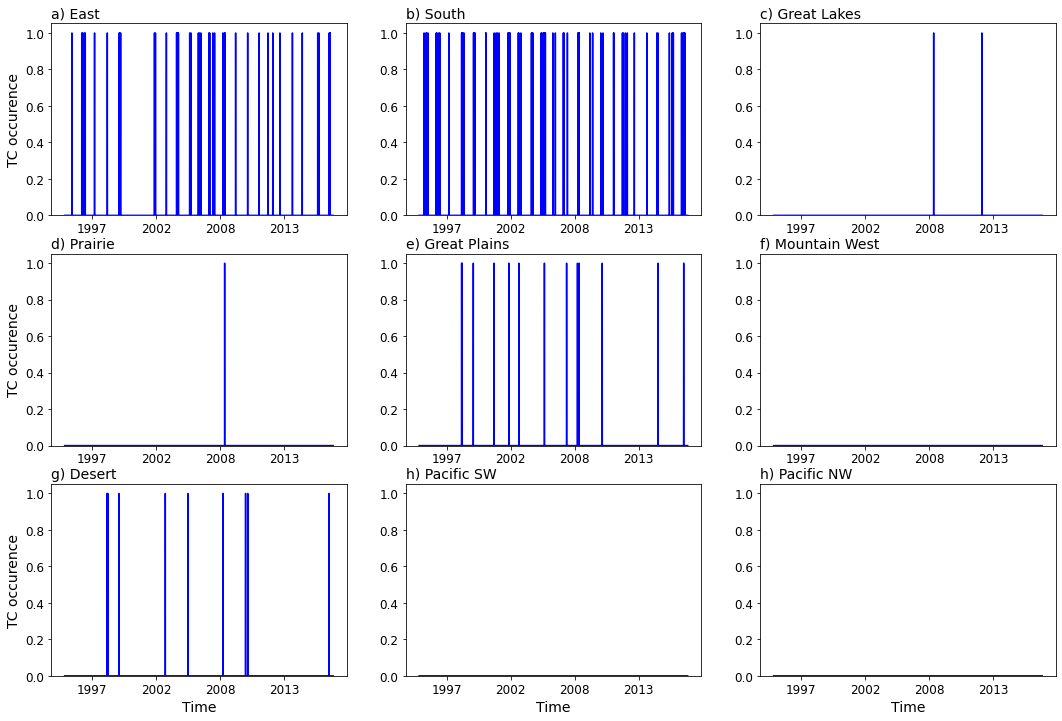

In [44]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig = plt.figure(figsize = (18,12))
date_plot = matplotlib.dates.date2num(tc_east_time['Date'])
date_fmt = matplotlib.dates.DateFormatter('%Y')

ax1 = plt.subplot(3, 3, 1, )
ax1.plot(date_plot, tc_east_time['Pmin'], c='b')
#ax1.set_xlabel('Time', fontsize=14)
ax1.set_ylabel('TC occurence', fontsize=14)
ax1.tick_params(axis='both',labelsize=12)
ax1.xaxis.set_major_formatter(date_fmt)
ax1.set_ylim(0,1.052)
ax1.set_title('a) East', loc='left', fontsize=14)

ax2 = plt.subplot(3, 3, 2,)
ax2.plot(date_plot, tc_south_time['Pmin'], c='b')
#ax2.set_xlabel('Time', fontsize=14)
#ax2.set_ylabel('TC occurence', fontsize=14)
ax2.tick_params(axis='both',labelsize=12)
ax2.xaxis.set_major_formatter(date_fmt)
ax2.set_ylim(0,1.052)
ax2.set_title('b) South', loc='left', fontsize=14)

ax3 = plt.subplot(3, 3, 3, sharex=ax1)
ax3.plot(date_plot, tc_lakes_time['Pmin'], c='b')
#ax3.set_xlabel('Time', fontsize=14)
#ax3.set_ylabel('TC occurence', fontsize=14)
ax3.tick_params(axis='both',labelsize=12)
ax3.xaxis.set_major_formatter(date_fmt)
#ax2.set_ylim(1995,2015)
ax3.set_ylim(0,1.052)
ax3.set_title('c) Great Lakes', loc='left', fontsize=14)


ax4 = plt.subplot(3, 3, 4,sharex=ax1)
ax4.plot(date_plot, tc_prr_time['Pmin'], c='b')
#ax4.set_xlabel('Time', fontsize=14)
ax4.set_ylabel('TC occurence', fontsize=14)
ax4.tick_params(axis='both',labelsize=12)
ax4.xaxis.set_major_formatter(date_fmt)
ax4.set_ylim(0,1.052)
ax4.set_title('d) Prairie', loc='left', fontsize=14)


ax5 = plt.subplot(3, 3, 5,sharex=ax2)
ax5.plot(date_plot, tc_gp_time['Pmin'], c='b')
#ax5.set_xlabel('Time', fontsize=14)
#ax5.set_ylabel('TC occurence', fontsize=14)
ax5.tick_params(axis='both',labelsize=12)
ax5.xaxis.set_major_formatter(date_fmt)
ax5.set_ylim(0,1.052)
ax5.set_title('e) Great Plains', loc='left', fontsize=14)


ax6 = plt.subplot(3, 3, 6,sharex=ax2)
ax6.plot(date_plot, tc_mnt_time['Pmin'], c='b')
#ax6.set_xlabel('Time', fontsize=14)
#ax6.set_ylabel('TC occurence', fontsize=14)
ax6.tick_params(axis='both',labelsize=12)
ax6.xaxis.set_major_formatter(date_fmt)
ax6.set_ylim(0,1.052)
ax6.set_title('f) Mountain West', loc='left', fontsize=14)


ax7 = plt.subplot(3, 3, 7,sharex=ax2)
ax7.plot(date_plot, tc_desert_time['Pmin'], c='b')
ax7.set_xlabel('Time', fontsize=14)
ax7.set_ylabel('TC occurence', fontsize=14)
ax7.tick_params(axis='both',labelsize=12)
ax7.xaxis.set_major_formatter(date_fmt)
ax7.set_ylim(0,1.052)
ax7.set_title('g) Desert', loc='left', fontsize=14)


ax8 = plt.subplot(3, 3, 8,sharex=ax2)
ax8.plot(date_plot, tc_pacsw_time['Pmin'], c='b')
ax8.set_xlabel('Time', fontsize=14)
#ax8.set_ylabel('TC occurence', fontsize=14)
ax8.tick_params(axis='both',labelsize=12)
ax8.xaxis.set_major_formatter(date_fmt)
ax8.set_ylim(0,1.052)
ax8.set_title('h) Pacific SW', loc='left', fontsize=14)


ax9 = plt.subplot(3, 3, 9,sharex=ax2)
ax9.plot(date_plot, tc_pacsw_time['Pmin'], c='b')
ax9.set_xlabel('Time', fontsize=14)
#ax9.set_ylabel('TC occurence', fontsize=14)
ax9.tick_params(axis='both',labelsize=12)
ax9.xaxis.set_major_formatter(date_fmt)
ax9.set_ylim(0,1.052)
ax9.set_title('h) Pacific NW', loc='left', fontsize=14)

plt.savefig('TC_id_Bukovsky_regions_1995–2017.png', bbox_inches='tight', transparent=False, facecolor='white', dpi=250)
plt.show()

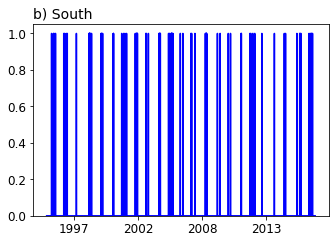

In [42]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig = plt.figure(figsize = (18,12))
date_plot = matplotlib.dates.date2num(tc_east_time['Date'])
date_fmt = matplotlib.dates.DateFormatter('%Y')


ax2 = plt.subplot(3, 3, 2,)
ax2.plot(date_plot, tc_south_time['Pmin'], c='b')
ax2.tick_params(axis='both',labelsize=12)
ax2.xaxis.set_major_formatter(date_fmt)
ax2.set_ylim(0,1.052)
ax2.set_title('b) South', loc='left', fontsize=14)
plt.show()